# HR Diagram

In [1]:
import pandas as pd

In [2]:
df_stars = pd.read_csv(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\venv\Exam\Data\stars.csv")

In [3]:
df_stars.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color', 'Spectral Class'],
      dtype='object')

Quick data exploration

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


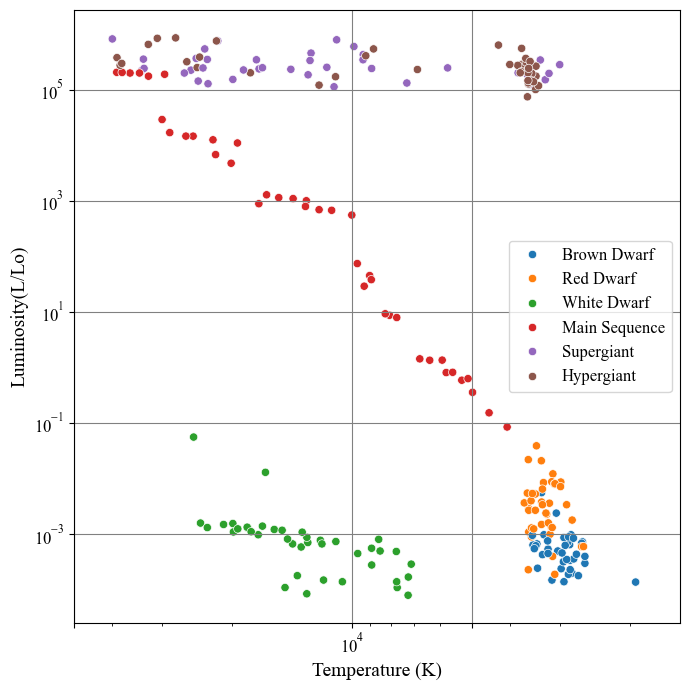

In [5]:
import seaborn as sns
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\venv\Utilities\utils.py")
from Utilities import plot_settings
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

In [6]:
import numpy as np
X = np.vstack([df_stars['Absolute magnitude(Mv)'].to_numpy(), df_stars['Luminosity(L/Lo)'].to_numpy(), df_stars['Radius(R/Ro)'].to_numpy(), df_stars['Temperature (K)'].to_numpy()]).T

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
pca = PCA(n_components=4, random_state=32)
X_pca = pca.fit_transform(X_scaled)

Text(0, 0.5, 'Explained variance ratio')

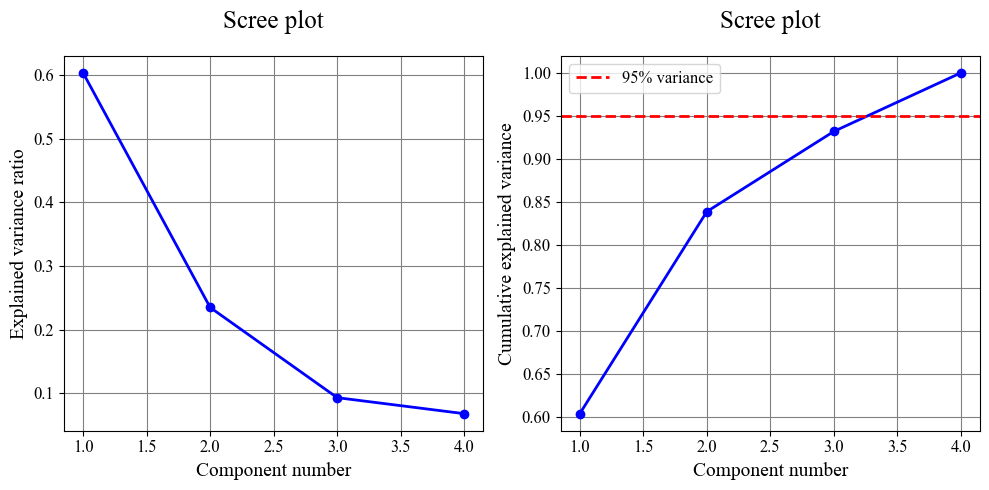

In [10]:
fig, axs = plt.subplots(1, 2)
axs[1].plot(range(1,5), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='blue')
axs[1].set_title('Scree plot')
axs[1].set_xlabel('Component number')
axs[1].axhline(0.95, 0, 1, linestyle='--', color='red', label='95% variance')
axs[1].set_ylabel('Cumulative explained variance')
axs[1].legend()

axs[0].plot(range(1,5), pca.explained_variance_ratio_, marker='o', linestyle='-', color='blue')
axs[0].set_title('Scree plot')
axs[0].set_xlabel('Component number')
axs[0].set_ylabel('Explained variance ratio')

We can thus use the first three of the four principal components, since they contain more then 90% of the explained variance. 

Text(0, 0.5, 'PCA component 1')

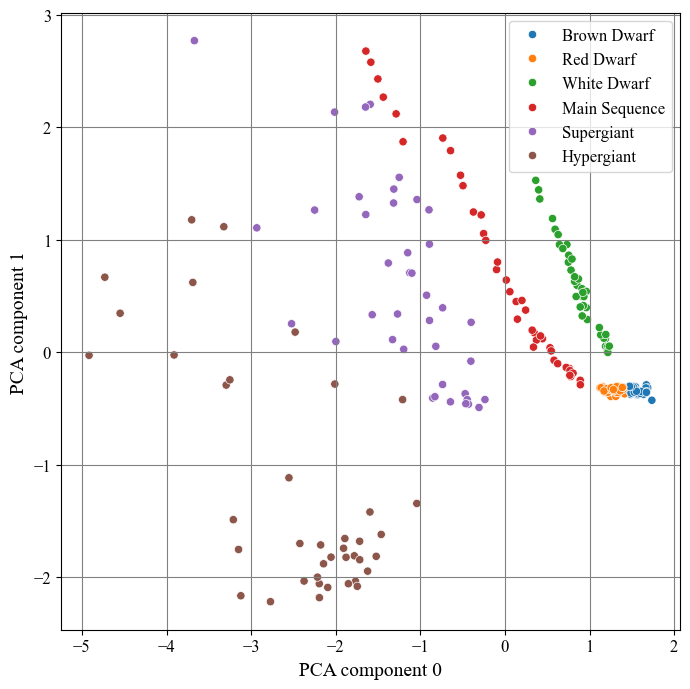

In [11]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels)
plt.xlabel("PCA component 0")
plt.ylabel("PCA component 1")